In [18]:
# ------------------------------------------------------------------------------ #
# @Author:        F. Paul Spitzner
# @Email:         paul.spitzner@ds.mpg.de
# @Created:       2024-03-23 16:05:20
# @Last Modified: 2024-03-23 16:05:38
# ------------------------------------------------------------------------------ #
# Here we run the bayesian analysis.
# Final plotting is done in a different notebook, as the analysis takes quite
# some time.
# ------------------------------------------------------------------------------ #

import os
import pymc as pm
import nutpie
import numpy as np
import pandas as pd
import arviz as az
import sys

import logging

logging.basicConfig(
    format="%(asctime)s | %(levelname)-8s | %(name)-s | %(funcName)-s | %(message)s",
    level=logging.WARNING,
)
log = logging.getLogger("notebook")
log.setLevel("DEBUG")

extra_path = os.path.abspath("../")
extra_path = os.path.abspath("/Users/paul/para/5_Archive/information_timescales/repo/_latest/experiment_analysis")
sys.path.append(extra_path)
log.info(f"project directory: {extra_path}")

from ana import utility as utl
from ana import plot_helper as ph
from ana import bayesian_models as bm

ph.log.setLevel("DEBUG")
utl.log.setLevel("DEBUG")

data_dir = "/Users/paul/para/5_Archive/information_timescales/repo/gnode.nosync/experiment_analysis/dat"

# load our results from timescale fitting
df = pd.read_hdf(f"{data_dir}/all_units_merged_blocks_with_spont.h5", key="meta_df")

# add metrics from image selectivity etc.
df = utl.load_metrics(
    df.reset_index(),
    data_dir,
    csvs=[
        # we need to combine data from different files, because we use spontaneous and natural movie stimuli
        "brain_observatory_1.1_analysis_metrics.csv",
        "functional_connectivity_analysis_metrics.csv",
    ],
    cols=["on_screen_rf"],
)
df = utl.add_structure_and_hierarchy_scores(df)
df = utl.load_experiments(df, data_dir)

# pymc does not like bools:
log.info(f'invalid metric rows: {df["on_screen_rf"].isna().sum()}')
df["on_screen_rf"] = df["on_screen_rf"].astype("int")

# some further preprocessing is done in the model class
# see ana/bayesian_models.py
df


2024-05-17 07:43:06,301 | INFO     | notebook | <module> | project directory: /Users/paul/para/5_Archive/information_timescales/repo/_latest/experiment_analysis
2024-05-17 07:43:11,079 | DEBUG    | its_utility | load_metrics | Loaded columns ['unit_id', 'on_screen_rf'] from /Users/paul/para/5_Archive/information_timescales/repo/gnode.nosync/experiment_analysis/dat/brain_observatory_1.1_analysis_metrics.csv
2024-05-17 07:43:11,358 | DEBUG    | its_utility | load_metrics | Loaded columns ['unit_id', 'on_screen_rf'] from /Users/paul/para/5_Archive/information_timescales/repo/gnode.nosync/experiment_analysis/dat/functional_connectivity_analysis_metrics.csv
2024-05-17 07:43:11,359 | INFO     | its_utility | load_metrics | Column on_screen_rf found in multiple dataframes.
2024-05-17 07:43:11,361 | DEBUG    | its_utility | load_metrics | Matched 6368 rows from meta_df in /Users/paul/para/5_Archive/information_timescales/repo/gnode.nosync/experiment_analysis/dat/brain_observatory_1.1_analysis_

,unit_id,stimulus,session,block,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,...,tau_R,tau_single,tau_double,tau_R_details,tau_single_details,tau_double_details,on_screen_rf,structure_name,hierarchy_score,session_type
0,950911932,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1078.491211,8.025100,/project.nst/neuroscience-raw/Allen/visual_cod...,8655,...,0.058510,0.000054,0.748946,"{'firing_rate': 8.012090922999178, 'firing_rat...","{'tau': 5.404084198337884e-05, 'mre': 6.575654...","{'tau': 0.7489462162647652, 'mre': 0.993346188...",0,AM,0.441,brain_observatory_1.1
1,950911986,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1079.203369,3.647135,/project.nst/neuroscience-raw/Allen/visual_cod...,3936,...,0.088701,2.302634,1.874703,"{'firing_rate': 3.6471291367256455, 'firing_ra...","{'tau': 2.3026338728859774, 'mre': 0.997830929...","{'tau': 1.874703126979266, 'mre': 0.9973364645...",0,AM,0.441,brain_observatory_1.1
2,950912164,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1077.872803,8.500075,/project.nst/neuroscience-raw/Allen/visual_cod...,9162,...,0.059416,1.026283,1.026284,"{'firing_rate': 8.475008697669026, 'firing_rat...","{'tau': 1.0262833654998276, 'mre': 0.995139899...","{'tau': 1.0262836602024297, 'mre': 0.995139901...",1,AM,0.441,brain_observatory_1.1
3,950912190,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1075.171875,4.399297,/project.nst/neuroscience-raw/Allen/visual_cod...,4730,...,0.116100,1.564297,1.363502,"{'firing_rate': 4.395563512916502, 'firing_rat...","{'tau': 1.5642971952849982, 'mre': 0.996808779...","{'tau': 1.363502294341311, 'mre': 0.9963396881...",1,AM,0.441,brain_observatory_1.1
4,950912214,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1073.492432,5.326540,/project.nst/neuroscience-raw/Allen/visual_cod...,5718,...,0.064748,0.605686,0.377801,"{'firing_rate': 5.317211538013684, 'firing_rat...","{'tau': 0.6056864214354767, 'mre': 0.991778883...","{'tau': 0.37780093267583975, 'mre': 0.98685270...",1,AM,0.441,brain_observatory_1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17944,950942400,spontaneous,771160300,null,VISal,SUCCESS,1797.115234,0.377828,/project.nst/neuroscience-raw/Allen/visual_cod...,679,...,0.049446,0.257024,0.217925,"{'firing_rate': 0.36583331347267567, 'firing_r...","{'tau': 0.25702383931940154, 'mre': 0.98073454...","{'tau': 0.2179251442600049, 'mre': 0.977317546...",0,AL,0.152,functional_connectivity
17945,950944614,spontaneous,771160300,null,VISal,SUCCESS,1792.901855,0.377600,/project.nst/neuroscience-raw/Allen/visual_cod...,677,...,0.042486,0.439570,0.057439,"{'firing_rate': 0.38629086027452963, 'firing_r...","{'tau': 0.4395698459887982, 'mre': 0.988689691...","{'tau': 0.05743850656844875, 'mre': 0.91663161...",0,AL,0.152,functional_connectivity
17946,950943984,spontaneous,771160300,null,VISal,SUCCESS,1773.977051,0.135289,/project.nst/neuroscience-raw/Allen/visual_cod...,240,...,0.043392,0.170987,0.170986,"{'firing_rate': 0.13628681470096451, 'firing_r...","{'tau': 0.1709865057191234, 'mre': 0.971181338...","{'tau': 0.17098641292634262, 'mre': 0.97118132...",0,AL,0.152,functional_connectivity
17947,950942680,spontaneous,771160300,null,VISal,SUCCESS,1801.591797,12.195324,/project.nst/neuroscience-raw/Allen/visual_cod...,21971,...,0.008184,0.081918,0.068260,"{'firing_rate': 12.154834329411557, 'firing_ra...","{'tau': 0.08191797577480081, 'mre': 0.94078874...","{'tau': 0.06826005692776223, 'mre': 0.92936912...",1,AL,0.152,functional_connectivity


         mu_intercept ~ Normal(0, 1)
      sigma_intercept ~ HalfCauchy(0, 1)
             mu_slope ~ Normal(0, 1)
          sigma_slope ~ HalfCauchy(0, 1)
    session_intercept ~ Normal(0, 1)
        session_slope ~ Normal(0, 1)
              b_os_rf ~ Normal(0, 1)
             b_log_fr ~ Normal(0, 1)
              epsilon ~ HalfCauchy(0, 10)
    eff_session_slope ~ Deterministic(f(session_slope, mu_slope, sigma_slope))
eff_session_intercept ~ Deterministic(f(session_intercept, mu_intercept, sigma_intercept))
           linear_fit ~ Deterministic(f(mu_intercept, mu_slope))
           likelihood ~ Normal(f(b_log_fr, b_os_rf, mu_intercept, mu_slope, session_intercept, sigma_intercept, session_slope, sigma_slope), epsilon)


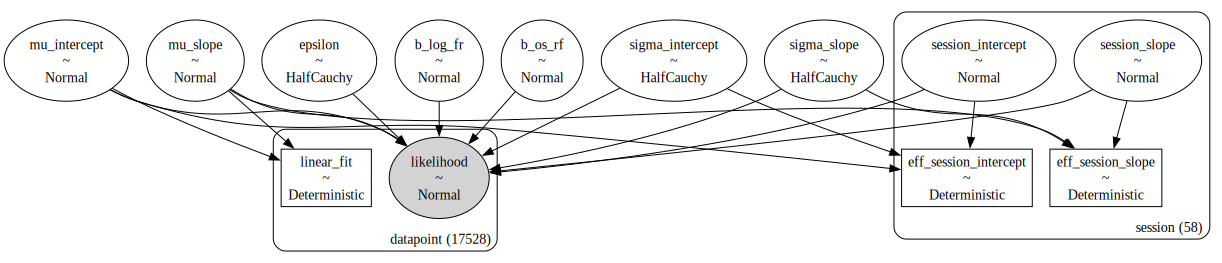

In [14]:
lm_R_tot = bm.LinearModel(df, "R_tot")
print(lm_R_tot.str_repr())
pm.model_to_graphviz(lm_R_tot)

         mu_intercept ~ Normal(0, 1)
      sigma_intercept ~ HalfCauchy(0, 0.1)
         mu_hc_offset ~ Normal(0, 1)
      sigma_hc_offset ~ HalfCauchy(0, 1)
         mu_th_offset ~ Normal(0, 1)
      sigma_th_offset ~ HalfCauchy(0, 1)
    session_intercept ~ Normal(0, 1)
    session_hc_offset ~ Normal(0, 1)
    session_th_offset ~ Normal(0, 1)
              b_os_rf ~ Normal(0, 1)
             b_log_fr ~ Normal(0, 1)
              epsilon ~ HalfCauchy(0, 10)
eff_session_hc_offset ~ Deterministic(f(session_hc_offset, mu_hc_offset, sigma_hc_offset))
eff_session_th_offset ~ Deterministic(f(session_th_offset, mu_th_offset, sigma_th_offset))
eff_session_intercept ~ Deterministic(f(session_intercept, mu_intercept, sigma_intercept))
           likelihood ~ Normal(f(b_log_fr, b_os_rf, mu_th_offset, mu_intercept, sigma_th_offset, session_th_offset, mu_hc_offset, session_intercept, sigma_intercept, sigma_hc_offset, session_hc_offset), epsilon)


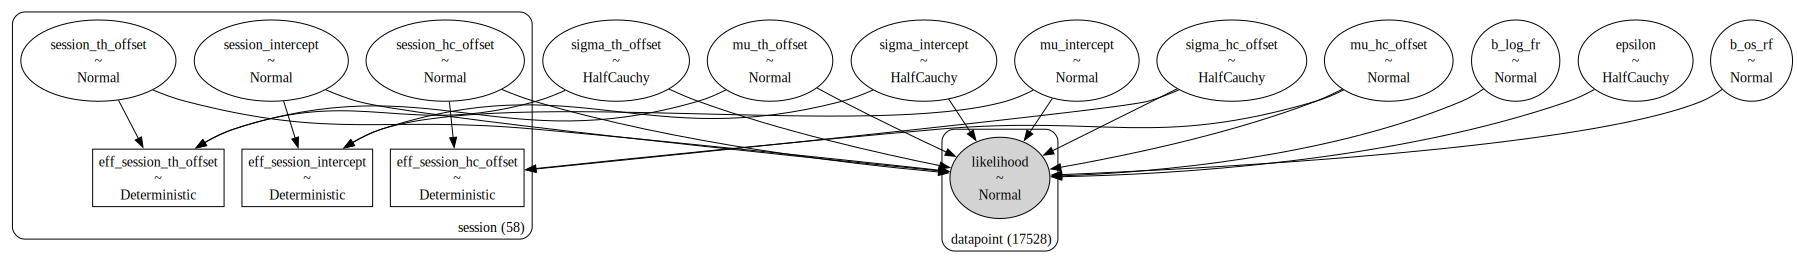

In [15]:
sgm_R_tot = bm.StructureGroupModel(df, "R_tot")
print(sgm_R_tot.str_repr())
pm.model_to_graphviz(sgm_R_tot)

# Example analysis for linear model and measure `R_tot`

In [16]:
with lm_R_tot:
    idata_lm_R_tot = pm.sample(
        nuts_sampler="nutpie",
        draws=3000,
        tune=2000,
        random_seed=42,
        target_accept=0.95,
    )

In [ ]:
with lm_R_tot:
    idata_lm_R_tot.extend(pm.sample_prior_predictive(random_seed=42))
    idata_lm_R_tot.extend(pm.sample_posterior_predictive(trace=idata_lm_R_tot, random_seed=42))

In [52]:
# idata_lm_R_tot.to_netcdf(f"{data_dir}/idata_lm_R_tot.nc") # ~ 1.8GB
idata_lm_R_tot

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

Warmup iterations saved (warmup_*).

In [22]:
az.summary(
    idata_lm_R_tot,
    var_names=[
        "b_log_fr",
        "b_os_rf",
        "epsilon",
        "mu_intercept",
        "mu_slope",
        "sigma_intercept",
        "sigma_slope",
        "session_slope",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_log_fr,-0.562,0.015,-0.591,-0.536,0.000,0.000,23116.0,8360.0,1.0
b_os_rf,0.031,0.015,0.002,0.059,0.000,0.000,17576.0,9713.0,1.0
epsilon,0.947,0.005,0.937,0.956,0.000,0.000,20685.0,7854.0,1.0
mu_intercept,0.040,0.027,-0.011,0.092,0.000,0.000,5213.0,6427.0,1.0
mu_slope,-0.044,0.021,-0.084,-0.005,0.000,0.000,7127.0,7909.0,1.0
...,...,...,...,...,...,...,...,...,...
session_slope[53],0.330,0.633,-0.879,1.508,0.005,0.005,14611.0,9569.0,1.0
session_slope[54],-0.914,0.638,-2.138,0.277,0.005,0.004,15648.0,9899.0,1.0
session_slope[55],-0.164,0.670,-1.398,1.124,0.006,0.006,13587.0,9244.0,1.0
session_slope[56],-0.205,0.632,-1.360,1.024,0.006,0.005,11685.0,8933.0,1.0


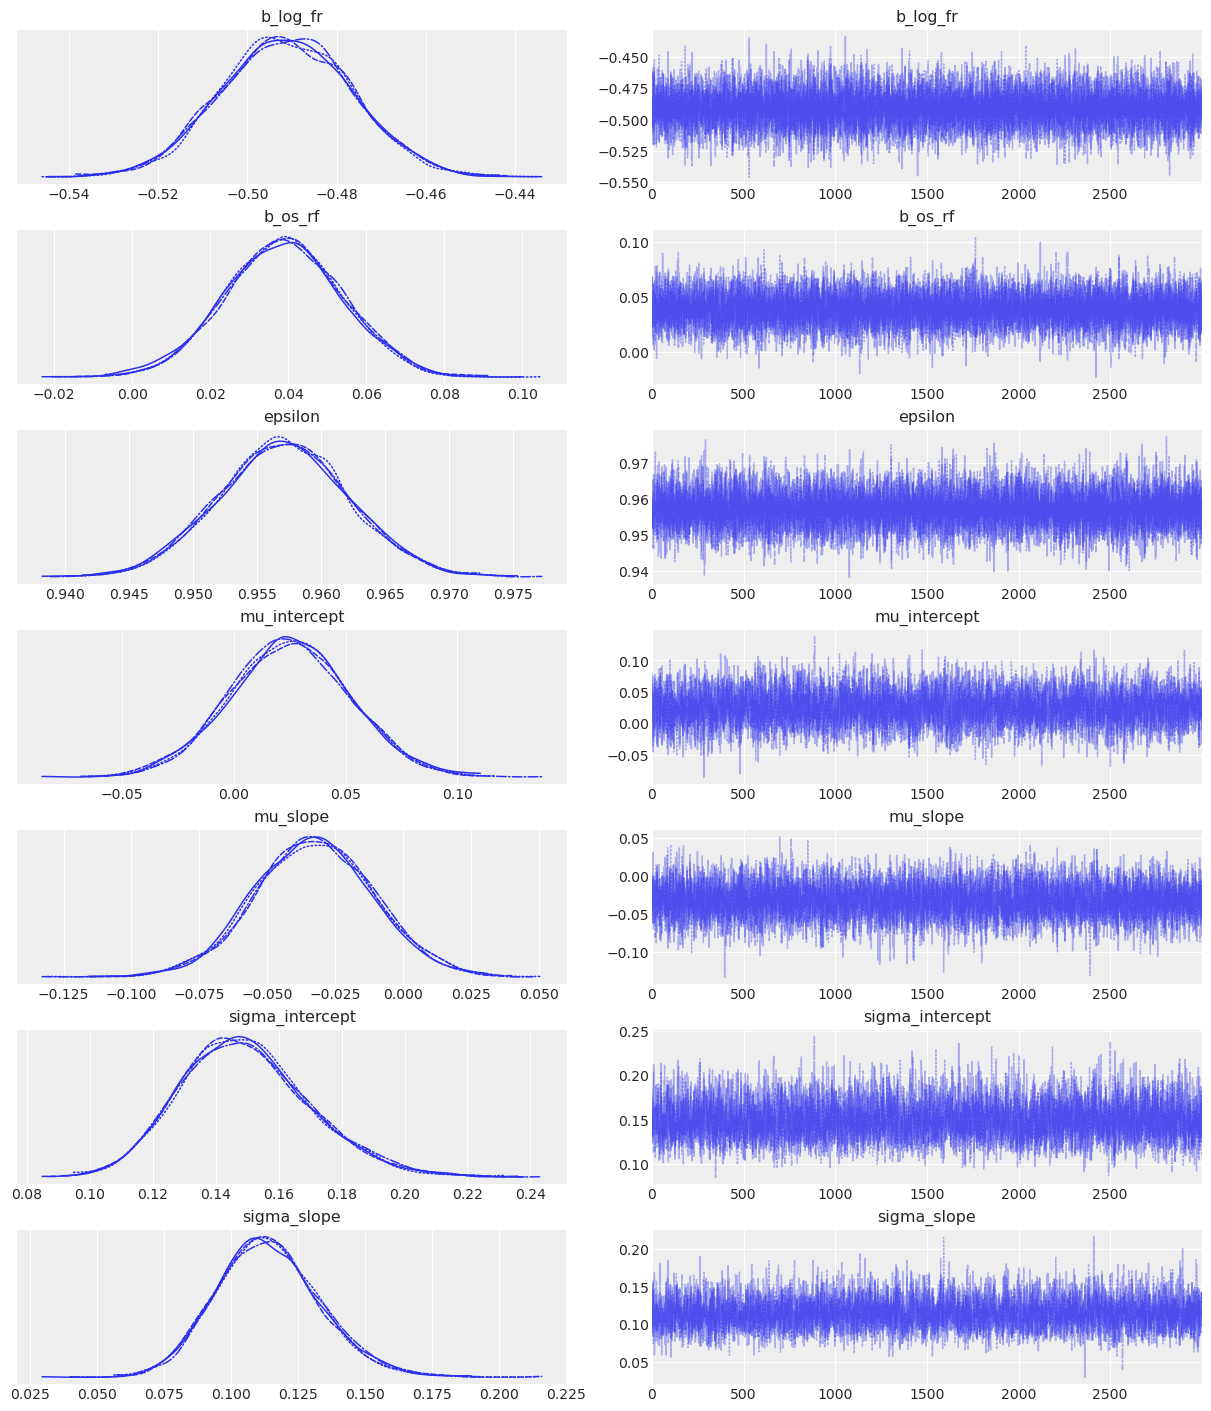

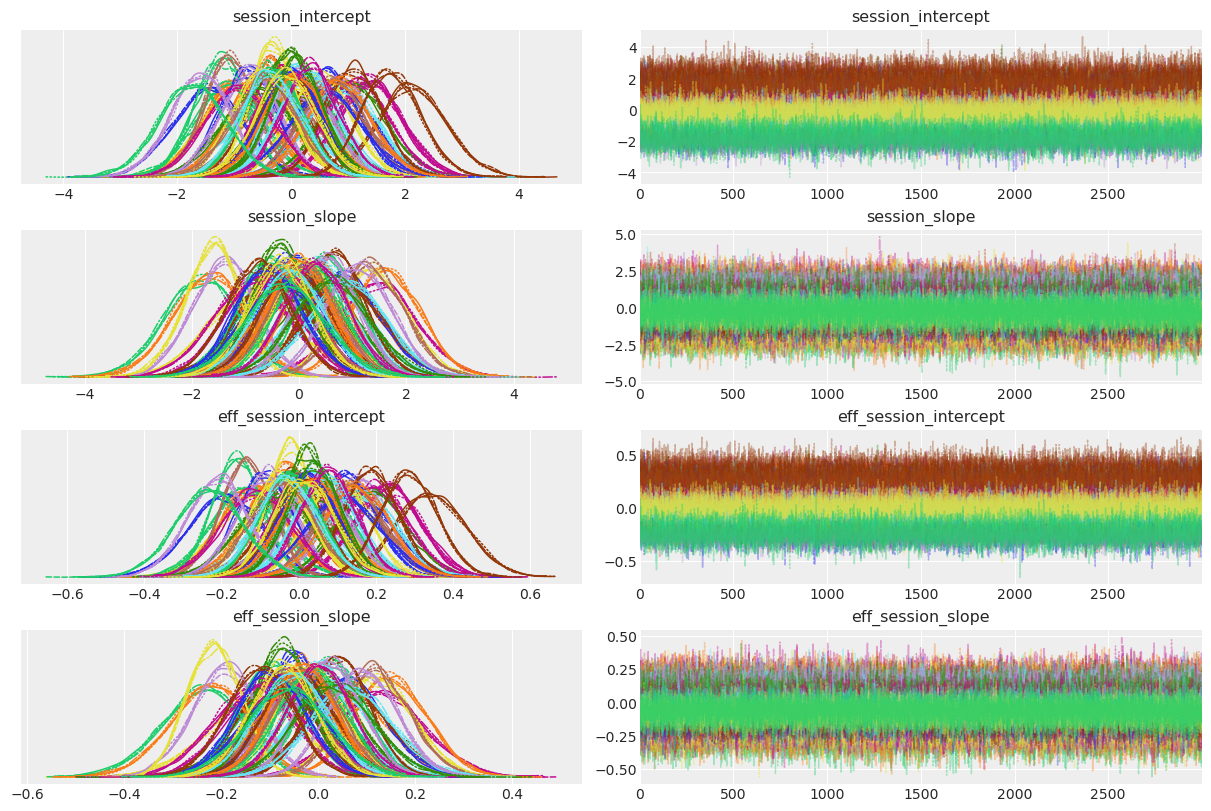

In [53]:
az.style.use("arviz-darkgrid")
# blue lines represent chains
az.plot_trace(
    idata_lm_R_tot,
    var_names=[
        "b_log_fr",
        "b_os_rf",
        "epsilon",
        "mu_intercept",
        "mu_slope",
        "sigma_intercept",
        "sigma_slope",
    ],
    legend=False,
);
# color varies across sessions
az.plot_trace(
    idata_lm_R_tot,
    var_names=[
        "session_intercept",
        "session_slope",
        "eff_session_intercept",
        "eff_session_slope",
    ],
    legend=False,
);

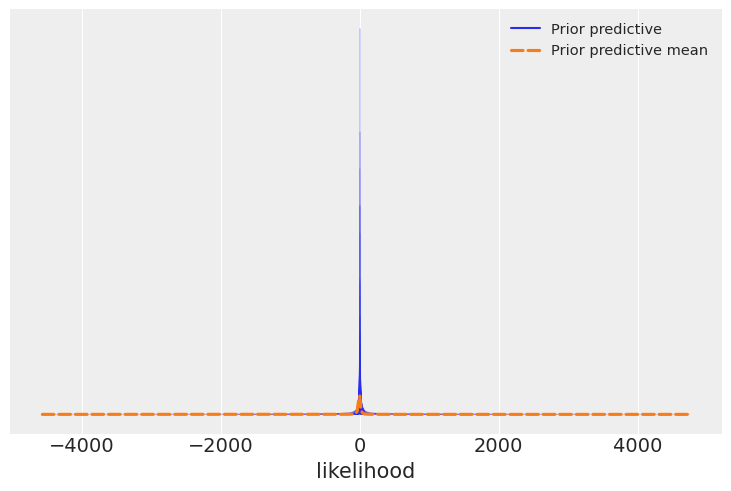

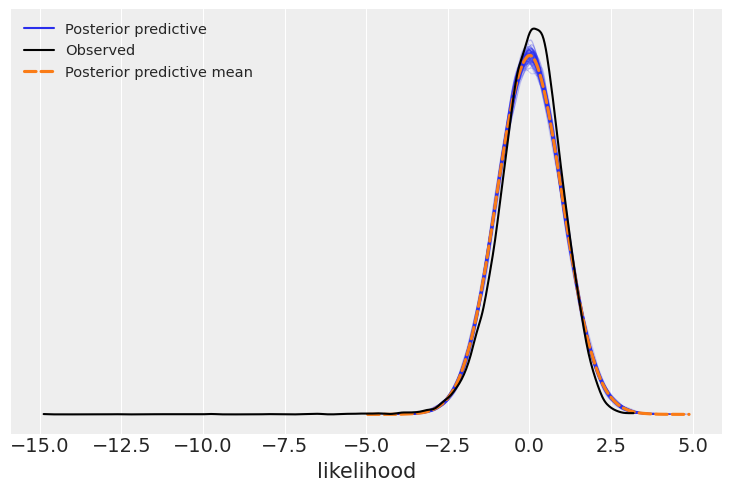

In [54]:
az.plot_ppc(
    idata_lm_R_tot,
    num_pp_samples=100,
    kind="kde",
    group="prior",
);
az.plot_ppc(
    idata_lm_R_tot,
    num_pp_samples=100,
    kind="kde",
    group="posterior",
);

# Generate traces for model comparison

In [105]:
# define models
models = dict()
models["lm_R_tot"] = bm.LinearModel(df, "R_tot")
models["lm_tau_R"] = bm.LinearModel(df, "tau_R")
models["lm_tau_double"] = bm.LinearModel(df, "tau_double")

models["sgm_R_tot"] = bm.StructureGroupModel(df, "R_tot")
models["sgm_tau_R"] = bm.StructureGroupModel(df, "tau_R")
models["sgm_tau_double"] = bm.StructureGroupModel(df, "tau_double")

In [ ]:
# ~1h on M1 mac
for name, model in models.items():
    with model:
        log.info(f"running model: {name}")
        idata = pm.sample(
            nuts_sampler="nutpie",
            draws=3000,
            tune=2000,
            random_seed=42,
            target_accept=0.95,
        )

        log.info(f"running ppc: {name}")
        idata.extend(pm.sample_prior_predictive(random_seed=42))
        idata.extend(pm.sample_posterior_predictive(trace=idata, random_seed=42))

        log.info(f"saving: {name}")
        idata.to_netcdf(f"{data_dir}/{name}.nc") # ~ 1.8GB each


# Reviewer Suggestion

In [ ]:
# TODO: compare `eff_session_hierarchy_slope` between spontaneous and natural movie three

models = dict()
models["lm_R_tot_spontaneous"] = bm.LinearModel(
    df.query('stimulus == "spontaneous"'), "R_tot"
)
models["lm_tau_R_spontaneous"] = bm.LinearModel(
    df.query('stimulus == "spontaneous"'), "tau_R"
)
models["lm_tau_double_spontaneous"] = bm.LinearModel(
    df.query('stimulus == "spontaneous"'), "tau_double"
)

models["lm_R_tot_nat_mov"] = bm.LinearModel(
    df.query('stimulus == "natural_movie_three"'), "R_tot"
)
models["lm_tau_R_nat_mov"] = bm.LinearModel(
    df.query('stimulus == "natural_movie_three"'), "tau_R"
)
models["lm_tau_double_nat_mov"] = bm.LinearModel(
    df.query('stimulus == "natural_movie_three"'), "tau_double"
)

models["sgm_R_tot_spontaneous"] = bm.StructureGroupModel(
    df.query('stimulus == "spontaneous"'), "R_tot"
)
models["sgm_tau_R_spontaneous"] = bm.StructureGroupModel(
    df.query('stimulus == "spontaneous"'), "tau_R"
)
models["sgm_tau_double_spontaneous"] = bm.StructureGroupModel(
    df.query('stimulus == "spontaneous"'), "tau_double"
)

models["sgm_R_tot_nat_mov"] = bm.StructureGroupModel(
    df.query('stimulus == "natural_movie_three"'), "R_tot"
)
models["sgm_tau_R_nat_mov"] = bm.StructureGroupModel(
    df.query('stimulus == "natural_movie_three"'), "tau_R"
)
models["sgm_tau_double_nat_mov"] = bm.StructureGroupModel(
    df.query('stimulus == "natural_movie_three"'), "tau_double"
)

for name, model in models.items():
    with model:
        log.info(f"running model: {name}")
        idata = pm.sample(
            nuts_sampler="nutpie",
            draws=3000,
            tune=2000,
            random_seed=42,
            target_accept=0.95,
        )

        log.info(f"saving: {name}")
        idata.to_netcdf(f"{data_dir}/{name}.nc")  # ~ 1.8GB each

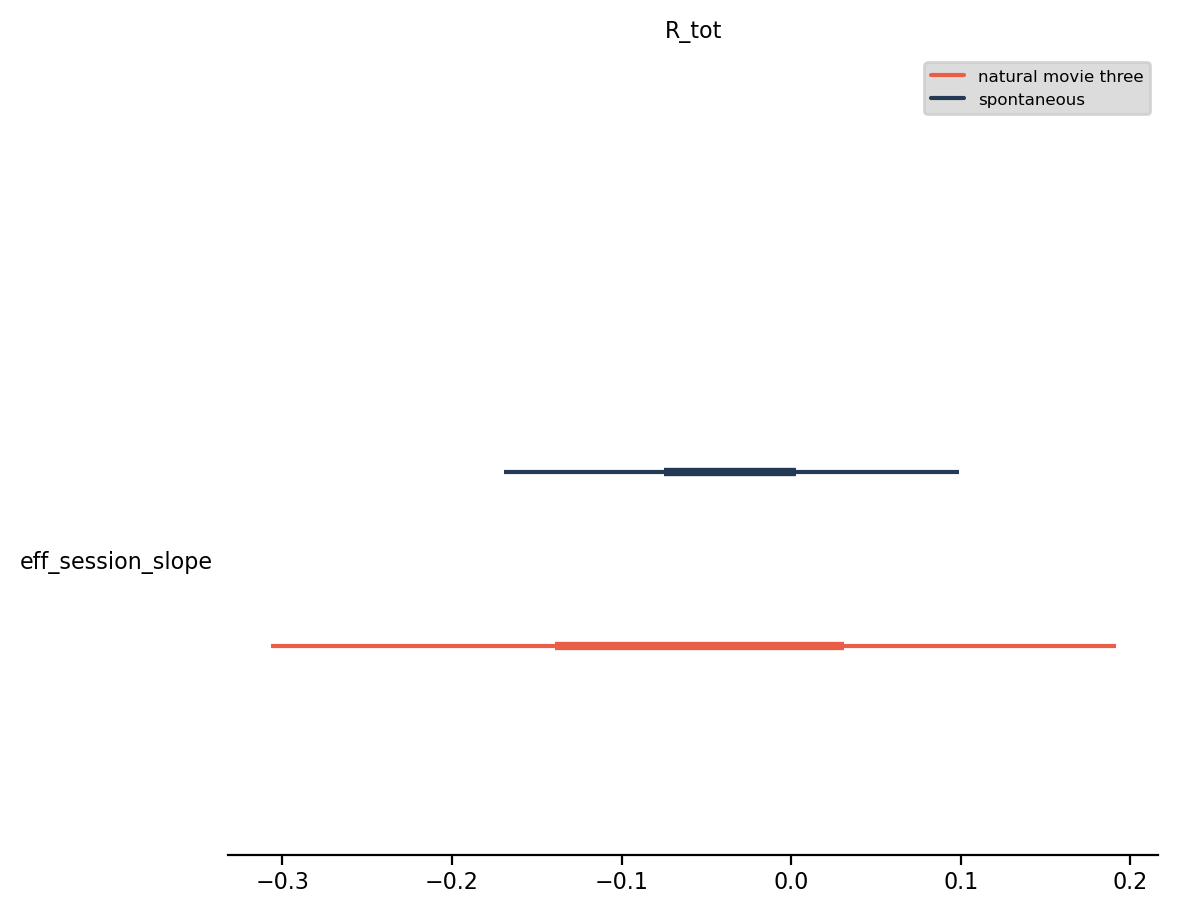

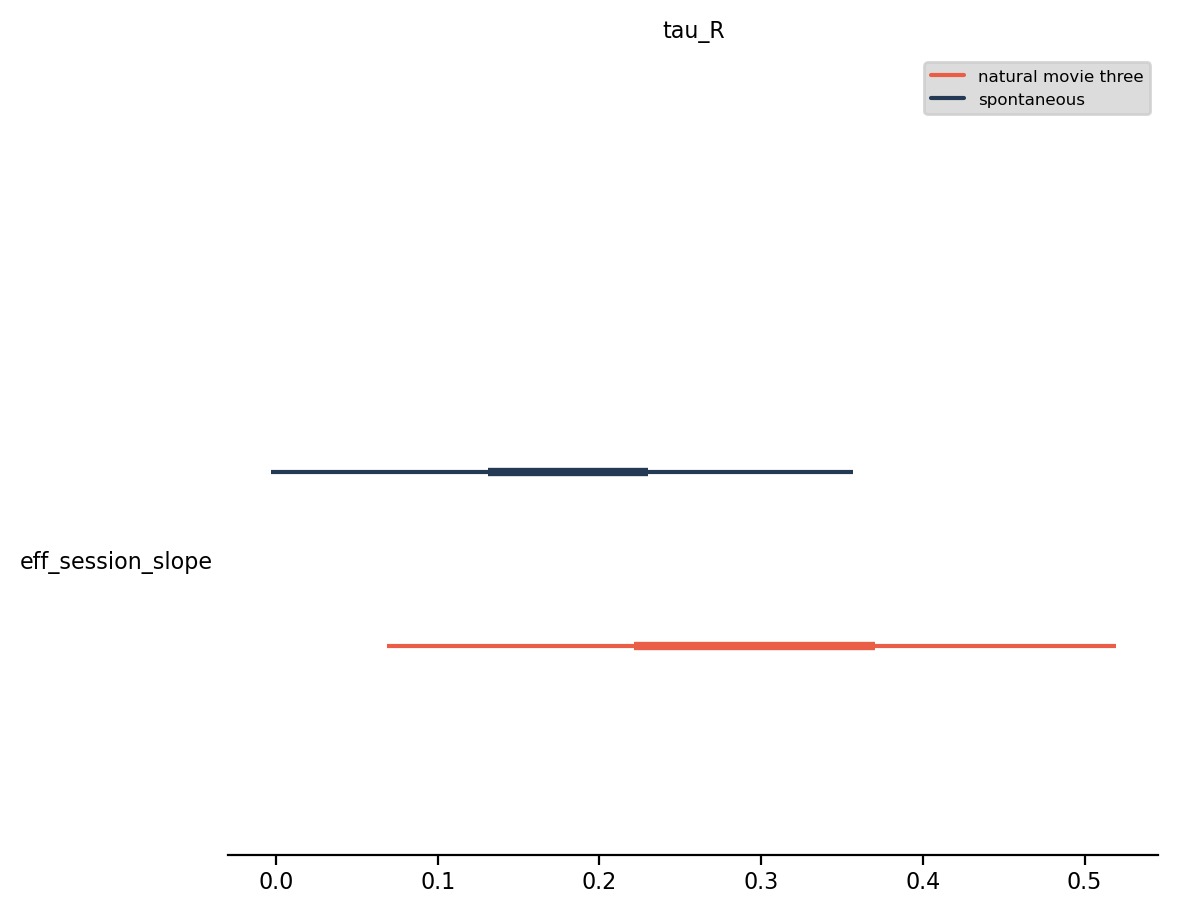

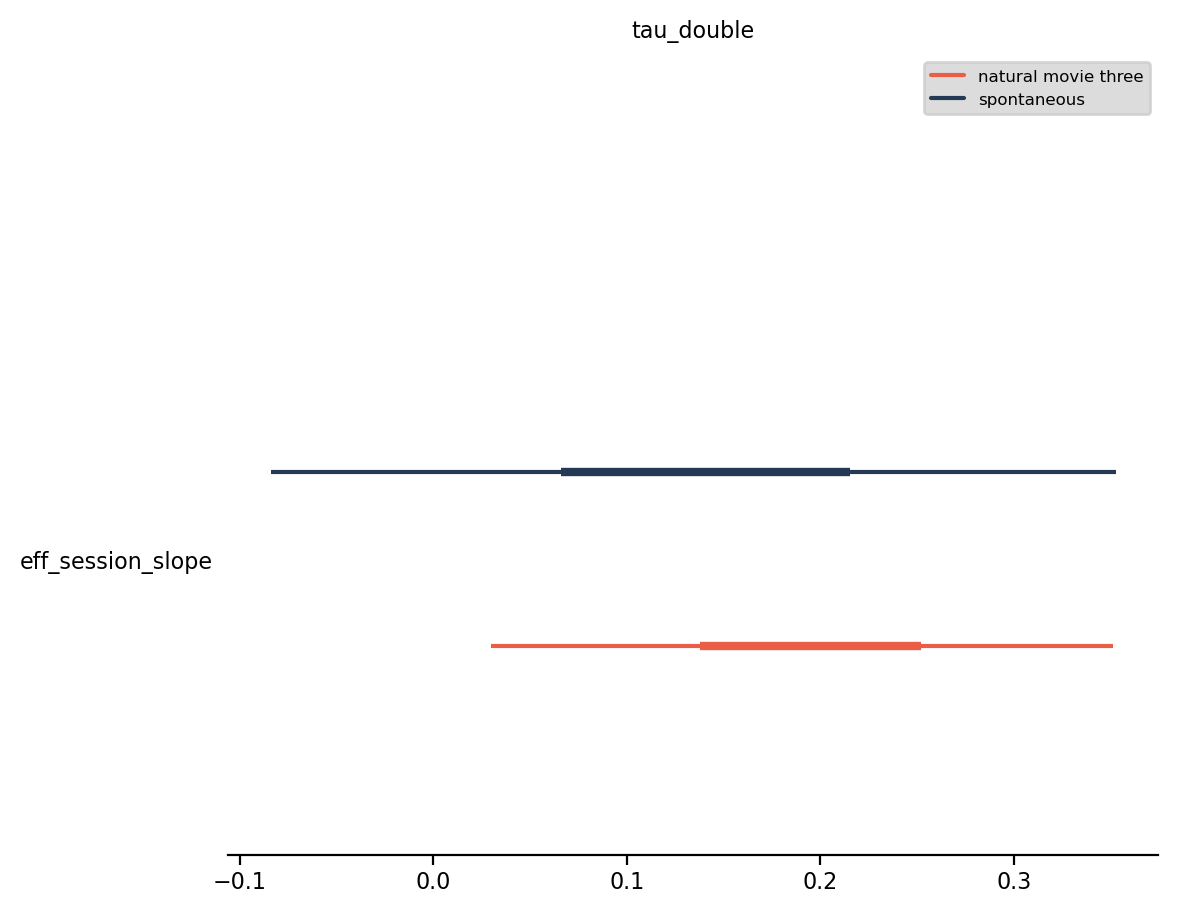

In [15]:
for obs in ["R_tot", "tau_R", "tau_double"]:
    idata_spont = az.from_netcdf(f"{data_dir}/lm_{obs}_spontaneous.nc")
    idata_nat_mov = az.from_netcdf(f"{data_dir}/lm_{obs}_nat_mov.nc")
    ax = az.plot_forest(
        [
            idata_spont,
            idata_nat_mov,
        ],
        model_names=["spontaneous", "natural movie three"],
        var_names=["eff_session_slope"],
        combined=True, # combines chains
        combine_dims=set(["draw", "session"]),
    )
    ax[0].set_title(obs)

<bound method DatasetAggregations.all of <xarray.Dataset> Size: 20MB
Dimensions:                (chain: 4, draw: 3000, session: 32)
Coordinates:
  * chain                  (chain) int64 32B 0 1 2 3
  * draw                   (draw) int64 24kB 0 1 2 3 4 ... 2996 2997 2998 2999
  * session                (session) int64 256B 0 1 2 3 4 5 ... 27 28 29 30 31
Data variables: (12/20)
    alpha                  (chain, draw) float64 96kB 2.208 2.213 ... 2.285
    b_log_fr               (chain, draw) float64 96kB 0.3408 0.3265 ... 0.3376
    b_os_rf                (chain, draw) float64 96kB -0.02937 ... -0.04446
    eff_session_hc_offset  (chain, draw, session) float64 3MB 0.01279 ... 0.1153
    eff_session_intercept  (chain, draw, session) float64 3MB -0.7812 ... -0....
    eff_session_th_offset  (chain, draw, session) float64 3MB -0.4827 ... -0....
    ...                     ...
    sigma_hc_offset        (chain, draw) float64 96kB 0.06826 0.0492 ... 0.1131
    sigma_hc_offset_log__  (chain,

In [21]:
%load_ext watermark
%watermark -v --iversions --packages nutpie,pymc,arviz

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.22.2

nutpie: 0.10.0
pymc  : 5.14.0
arviz : 0.18.0

pandas        : 2.0.3
prompt_toolkit: 3.0.42
scipy         : 1.13.0
sqlite3       : 2.6.0
pymc          : 5.14.0
sys           : 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:34:54) [Clang 16.0.6 ]
logging       : 0.5.1.2
IPython       : 8.22.2
patsy         : 0.5.6
matplotlib    : 3.8.4
numpy         : 1.24.4
arviz         : 0.18.0

